In [4]:
import getpass, ipywidgets as ipw, os, json, shlex, io, re, tempfile, subprocess,unittest
import datetime
import pydicom,numpy as np,csv,warnings,pickle,sys,tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from IPython.display import FileLink

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

%load_ext autoreload
%autoreload 2
#%tb

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from juxnat_lib.xnat_utils import *

/nrgpackages/packages/tensorflow-cpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/nrgpackages/packages/tensorflow-cpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/nrgpackages/packages/tensorflow-cpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/nrgpackages/packages/tensorflow-cpu/lib

In [5]:
class HOF_Classifier:
    def __init__(self):
        self.classifier=[]
        self.vectorizer=[]
        self._class_vectorizer=None
        #important: must be in aphpabetical order for vectorizer to work correctly.
        self._classes=['CBF','CBV','DSC','DWI','FA','MD','MPRAGE','MTT','OT','PBP','SWI','T1hi','T1lo','T2FLAIR','T2hi','T2lo','TRACEW','TTP']
        #self._scan_list=[]
    def load_json(self, json_file):
        with open(json_file, 'r') as fp:
            out_dict=json.loads(fp.read())
        return out_dict    
    def save_json(self, var, file):
        with open(file,'w') as fp:
            json.dump(var, fp) 
    '''
    Assign HOF ID's to scans using associative table look-up.
    '''
    def assign_hofids_slist(self,scans):
        for s in scans:
            descr=re.sub(' ','',s['series_description'])
            cmd="slist qd "+"\"" + descr + "\""
            try:
                hof_id=os.popen(cmd).read().split()[1]
            except:
                hof_id=""
            #print(hof_id)
            s['hof_id']=hof_id
            #out.value="{}/{}".format(s['series_description'],hof_id)
        return scans
    
    def write_scans_csv(self, scans, file):
        with open(file, 'w') as output_file:
            dict_writer = csv.DictWriter(output_file, scans[0].keys())
            dict_writer.writeheader()
            dict_writer.writerows(scans)
            
    def read_scans_csv(self, file):
        with open(file,'r') as inf:
            reader = csv.DictReader(inf)
            scans=[{k: str(v) for k,v in row.items()} 
                      for row in csv.DictReader(inf,skipinitialspace=True)]
        return scans    
       
    '''
    Create vocabulary from the bag of words. These will act as features.
    '''
    def gen_vocabulary(self,scans):
        descs=self.prepare_descs(scans)
        vectorizer=CountVectorizer(min_df=0)
        vectorizer.fit(descs)
        self.vectorizer=vectorizer
        print('the length of vocabulary is ',len(vectorizer.vocabulary_))
     
    #for logreg/svm output, categorical labels are stored as strings
    def prepare_training_vectors(self,scans):
        #labels vector.
        vectorized_descs=self.gen_bow_vectors(scans)
        y=[ s['hof_id'] for s in scans ]
        return vectorized_descs,y
    
    #for a NN output, categorical labels are stored as BOW over vocabulary of class labels.
    def prepare_training_vectors_nn(self,scans,gen_hofids=True):
        if self._class_vectorizer is None:
            vectorizer=CountVectorizer(min_df=0)
            vectorizer.fit(self._classes)
            self._class_vectorizer=vectorizer
        vectorizer=self._class_vectorizer
        vectorized_descs=self.gen_bow_vectors(scans)
        hofids=[ s['hof_id'] for s in scans ] if gen_hofids else []        
        return vectorized_descs,vectorizer.transform(hofids).toarray()
    
    def prepare_descs(self,scans):
        #descs are 'sentences' that contain series description and log-compressed number of frames.
        descs=[]
        for s in scans:
            desc=(re.sub('[^0-9a-zA-Z ]+',' ',s['series_description'])).split()
            #compressed representation of the number of frames.
            try:
                frames='frames{}'.format(str(int(np.around(np.log(1.0+float(s['frames']))*3.0))))
            except:
                frames='frames0'
            desc.append(frames)
            descs.append(' '.join([s for s in desc if ((not s.isdigit()) and (len(s)>1)) ]))
        return descs
        
    def gen_bow_vectors(self,scans):
        if not self.vectorizer: return []
        descs=self.prepare_descs(scans)
        return self.vectorizer.transform(descs).toarray()    
    
    def train_nn(self,X,y,test_split,epochs=10,batch_size=10, random_state=1000):
        X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_split,random_state=random_state)
        input_dim=X_train.shape[1]
        print('input_dim:',input_dim)
        model = Sequential()
        model.add(layers.Dense(36,input_dim=input_dim,activation='relu'))
        #model.add(layers.Dense(18,activation='relu'))
        model.add(layers.Dense(len(self._classes),activation='sigmoid'))
        print('output_dim:',len(self._classes))
        model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy','categorical_accuracy'])
        model.summary()
        self.classifier=model
        #self.classifier.fit(X_train,y_train,epochs=10,verbose=True,validation_data=(X_test,y_test),batch_size=10)
        hist=self.classifier.fit(X_train,y_train,epochs=epochs,verbose=True,validation_data=(X_test,y_test),batch_size=batch_size)
        self.plot_nn_train_history(hist)
        
    def plot_nn_train_history(self,history):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        x = range(1, len(acc) + 1)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(x, acc, 'b', label='Training acc')
        plt.plot(x, val_acc, 'r', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(x, loss, 'b', label='Training loss')
        plt.plot(x, val_loss, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        
    def infer_nn(self,scans):
        vecs,ids=self.prepare_training_vectors_nn(scans,False)
        y_fit=self.classifier.predict(vecs)        
        hofids=[ self._classes[np.argmax(y_fit[i])] for i in range(len(y_fit)) ]
        return hofids        
        
    def train_classifier(self,X,y,test_split,random_state=1000):
        descs_train,descs_test,y_train,y_test=train_test_split(X,y,test_size=test_split,random_state=random_state)
        #classifier=LogisticRegression()
        classifier=LinearSVC()
        #classifier=SVC()
        classifier.fit(descs_train,y_train)
        scoreTest=classifier.score(descs_test,y_test)
        scoreTrain=classifier.score(descs_train,y_train)
        print('Test accuracy:', scoreTest, " train accuracy:",scoreTrain)        
        self.classifier=classifier
        
        return classifier
    
    def _merge_hofids(self,scans,hofids):
        for s in scans:
            descr=re.sub(' ','',s['series_description'])
            cmd="slist qd "+"\"" + descr + "\""
            try:
                hof_id=os.popen(cmd).read().split()[1]
            except:
                hof_id=""
            #print(hof_id)
            s['hof_id']=hof_id
            out.value="{}/{}".format(s['series_description'],hof_id)
        
    def _predict_classifier(self,X):
        if not self.classifier: return []
        return self.classifier.predict(X)
    
    def predict_classifier_nn(self,scans):
        hofids=self.infer_nn(scans)
        for s,h in zip(scans,hofids):
            s['hof_id']=h
        return scans
    
    def predict_classifier(self, scans):
        vectorized_descs=self.gen_bow_vectors(scans)
        labels=self._predict_classifier(vectorized_descs)
        for i,s in enumerate(scans):
            s['hof_id']=labels[i]
        return scans
    
    def is_valid_model(self):
        return (self.vectorizer and self.classifier)    
        
    def save_model_nn(self,rt):
        pickle.dump(self.vectorizer,open(rt+'.vec','wb'))
        self.classifier.save(rt+'.hd5')
        
    def load_model_nn(self,rt):
        self.vectorizer=pickle.load(open(rt+'.vec','rb'))
        self.classifier=tf.keras.models.load_model(rt+'.hd5')
    
    def save_model(self, file):
        pickle.dump([self.vectorizer,self.classifier],open(file,'wb'))
                    
    def load_model(self, file):
        self.vectorizer,self.classifier=pickle.load(open(file,'rb'))

In [7]:
sp=ServerParams('test_input.txt')

#iterate over scans in a given project.
#xnat_iterator=XnatIterator(sp)
#xnat_iterator.connect()

#text area with progress.
out = ipw.Textarea(layout={'border': '1px solid black','width':'500px'})
out

Textarea(value='', layout=Layout(border='1px solid black', width='500px'))

In [ ]:
#build a list of scans.
scan_res_file='scan_results.json'
subjects=xnat_iterator.list_subjects()
print ('number of subjects: {}'.format(len(subjects)))
#scans=xnat_iterator.list_scans(subjects,'MW',scan_res_file,out)
exps=xnat_iterator.list_scans_all(subjects,'S0',scan_res_file,out)

In [ ]:
scans=[ scan for e in exps for scan in e ]
print ('the length of scans is',len(scans))

In [8]:
hof_cl=HOF_Classifier()
#hof_cl.load_model('./scan_classifier_nn.11.26.2019.pkl')
#hof_cl.write_scans_csv(scans,'scan_results_condr_sh.csv')

In [9]:
len(hof_cl._classes)

18

In [10]:
vectorizer.transform([]).toarray()

NameError: name 'vectorizer' is not defined

In [ ]:
#flatten scans.
exps=hof_cl.load_json('scan_results.json')
scans=[ scan for e in exps for scan in e ]
print ('the length of scans is',len(scans))

In [ ]:
#assign known labels (HOF IDs)
scans=hof_cl.assign_hofids_slist(scans)
hof_cl.save_json(scans,'scan_results_hofid.json')
hof_cl.write_scans_csv(scans,'scan_results_hofid.csv')    

In [21]:
#load edited csv, with updated labels.
scans=hof_cl.read_scans_csv('all_scans_hofid.csv')
#scans=hof_cl.read_scans_csv('scan_results_hofid_labeled.csv')
#scans=hof_cl.read_scans_csv('scan_labeled_mets.csv')
#scans=hof_cl.read_scans_csv('scan_labeled_mets_condr.csv')
#scans=hof_cl.read_scans_csv('scan_labeled_mets_condr_tcga.csv')
#scans=hof_cl.read_scans_csv('scan_labeled_mets_condr_tcga_sh.csv')
#scans=hof_cl.read_scans_csv('scans_labeled_TCGA.csv')
#scans=hof_cl.read_scans_csv('scans_labeled_TCGA_sh.csv')
#scans=hof_cl.read_scans_csv('scans_labeled_TCGA_sh_condr.csv')


In [22]:
#prepare the data vectors.
hof_cl.gen_vocabulary(scans)

the length of vocabulary is  524


In [23]:
scans[0]

{'xnat_imagescandata_id': '2584890',
 'frames': '3',
 'series_description': 'LOCALIZER',
 'ID': '1',
 'type': 'localizer',
 'URI': '/data/experiments/CNDA6_E01454/scans/1',
 'subject': 'I3CR0001',
 'experiment': 'I3CR0001_MR_d0000',
 'hof_id': 'OT'}

In [24]:
descs,y=hof_cl.prepare_training_vectors_nn(scans)

In [25]:
y.shape

(39373, 18)

In [26]:
hof_cl.train_nn(descs,y,0.11,30,10,1000)

input_dim: 524
output_dim: 18
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 36)                18900     
_________________________________________________________________
dense_1 (Dense)              (None, 18)                666       
Total params: 19,566
Trainable params: 19,566
Non-trainable params: 0
_________________________________________________________________
Train on 35041 samples, validate on 4332 samples
Epoch 1/30
35041/35041 [==============================] - 2s 68us/sample - loss: 0.0451 - acc: 0.9890 - categorical_accuracy: 0.9162 - val_loss: 0.0046 - val_acc: 0.9989 - val_categorical_accuracy: 0.9898
Epoch 2/30
35041/35041 [==============================] - 3s 75us/sample - loss: 0.0028 - acc: 0.9993 - categorical_accuracy: 0.9948 - val_loss: 0.0021 - val_acc: 0.9993 - val_categorical_accuracy: 0.9942
Epoch 3/30
35041/35041 [=

KeyboardInterrupt: 

In [227]:
#scans_condr_sh=hof_cl.read_scans_csv('scan_labeled_mets.csv')
tscans=scans

hofids=hof_cl.infer_nn(tscans)
n=0
for i in range(len(tscans)):
    if hofids[i]!=tscans[i]['hof_id']:
        print('position: {}, predicted: {}, actual: {}'.format(i,hofids[i],tscans[i]['hof_id']))
        n+=1
print(1-n/len(tscans))

position: 427, predicted: DWI, actual: OT
position: 979, predicted: T2lo, actual: OT
position: 1018, predicted: OT, actual: DWI
position: 1492, predicted: DWI, actual: OT
position: 1865, predicted: OT, actual: T1lo
position: 1981, predicted: OT, actual: T1lo
position: 2312, predicted: T2lo, actual: T2hi
position: 2482, predicted: FA, actual: OT
position: 2757, predicted: OT, actual: T2lo
position: 3393, predicted: T2lo, actual: OT
position: 3885, predicted: T2lo, actual: OT
position: 4407, predicted: T1lo, actual: OT
position: 4607, predicted: OT, actual: T2lo
position: 4773, predicted: DWI, actual: OT
position: 6171, predicted: T1hi, actual: OT
position: 6572, predicted: OT, actual: T2lo
position: 7295, predicted: DWI, actual: OT
position: 7305, predicted: DWI, actual: OT
position: 7961, predicted: T1lo, actual: OT
position: 8253, predicted: T1lo, actual: T1hi
position: 9177, predicted: T2FLAIR, actual: OT
position: 10331, predicted: OT, actual: T1lo
position: 10903, predicted: T2lo, 

In [10]:
hof_cl.save_model_nn('/home/wustl/mmilchenko/src/scan_classifier/scan_classifier_nn.11.26.2019')

In [ ]:
hof_cl1=HOF_Classifier()
hof_cl1.load_model_nn('/home/wustl/mmilchenko/temp/scan_classifier_nn.11.26.2019')

In [ ]:
hof_cl1.classifier

In [ ]:
pickle.dump([hof_cl.vectorizer,hof_cl.classifier],open('/home/wustl/mmilchenko/temp/scan_classifier_nn.11.26.2019.pkl','wb'))

In [173]:
descs,y=hof_cl.prepare_training_vectors(scans)

In [174]:
#build logistic regression model.
logreg=hof_cl.train_classifier(descs,y,0.2,1000)
#hof_cl.save_model('logreg_model_condr_mets.pkl')

Test accuracy: 0.9883783492951684  train accuracy: 0.9936504520017219


In [228]:
#mets data
scans_mets=hof_cl.read_scans_csv('scan_labeled_mets.csv')
print ('the number of scans is',len(scans_mets))
#scans_mets1=hof_cl.predict_classifier(scans_mets)
scans_mets1=hof_cl.predict_classifier_nn(scans_mets)

mismatches=[ scans_mets1[i] for i in range(0,len(scans_mets1)) if scans_mets1[i]['hof_id']!=scans_mets1[i]['hof_id0'] ]
failrate=1-len(mismatches)/len(scans_mets)
print ("mets accuracy: "+str(failrate) )

the number of scans is 20365
mets accuracy: 0.9968573533022342


In [193]:
scans_mets1[0]

'OT'

In [229]:
scans_condr=hof_cl.read_scans_csv('scans_labeled_CONDR.csv')
print ('the number of scans is',len(scans_condr))
scans_condr1=hof_cl.predict_classifier_nn(scans_condr)
mismatches=[ scans_condr1[i] for i in range(0,len(scans_condr1)) if scans_condr1[i]['hof_id']!=scans_condr1[i]['hof_id0'] ]
failrate=1-len(mismatches)/len(scans_condr)
print ("condr accuracy: "+str(failrate) )

the number of scans is 14063
condr accuracy: 0.9982222854298514


In [230]:
scans_tcga=hof_cl.read_scans_csv('scans_labeled_TCGA.csv')
print ('the number of scans is',len(scans_tcga))
scans_tcga1=hof_cl.predict_classifier_nn(scans_tcga)
mismatches=[ scans_tcga1[i] for i in range(0,len(scans_tcga1)) if scans_tcga1[i]['hof_id']!=scans_tcga1[i]['hof_id0'] ]
failrate=1-len(mismatches)/len(scans_tcga)
print ("tcga accuracy: "+str(failrate) )

the number of scans is 5410
tcga accuracy: 0.9805914972273567


In [232]:
#condr sh data
scans_condr_sh=hof_cl.read_scans_csv('scans_labeled_sh.csv')
print ('the number of scans is',len(scans_condr_sh))
scans_condr_sh1=hof_cl.predict_classifier_nn(scans_condr_sh)
mismatches=[ scans_condr_sh1[i] for i in range(0,len(scans_condr_sh1)) if scans_condr_sh1[i]['hof_id']!=scans_condr_sh1[i]['hof_id0'] ]
failrate=1-len(mismatches)/len(scans_condr_sh)
print ("mets accuracy: "+str(failrate) )

the number of scans is 6623
mets accuracy: 0.994413407821229


In [249]:
#performance on different training sets
T=np.array([[99.6, 99.6, 99.5, 99.5], [98.1, 99.8, 99.7, 99.6], [71.0,74.0,98.1,97.8],[66.7, 77.5, 92.0, 99.3]])
x=np.array([1,2,3,4])

In [25]:
def plot_all_datasets_one_classifier(T,ylab):
    matplotlib.style.use('default')
    leg=["1 (METS-WU)", "2 (CONDR-WU)", "3 (TCGA-GBM)", "4 (CONDR-SH)"]
    ticks=[1,2,3,4];
    tick_labels=["1","1+2","1+2+3","1+2+3+4"]
    l,t,tl=leg,ticks,tick_labels    
    for i in range(0,4):         
        plot(t,T[i][:],'-o',label=l[i])
    legend(); xlabel('Training dataset'); ylabel(ylab); 
    xticks(t,tl);
    
def plot_one_dataset_all_classifiers(Td,dataset_index):
    matplotlib.style.use('default')
    datasets=["1 (METS-WU)", "2 (CONDR-WU)", "3 (TCGA-GBM)", "4 (CONDR-SH)"]
    leg=["Logreg","SVM", "NN" ]
    ticks=[1,2,3,4]
    tick_labels=["1","1+2","1+2+3","1+2+3+4"]
    l,t,tl,di=leg,ticks,tick_labels,dataset_index
    for i in range(0,3):
        #print("i=",i,"di=",di)
        plot(t,Td[i,di,:],'-o',label=l[i])
    legend(); xlabel('Training dataset'); ylabel("Accuacy on dataset "+datasets[di]); xticks(t,tl)
    
    

In [15]:
#multinomial regression performance.
reg_acc=[[99.2, 99.2, 99.1, 99.1],[98.8,99.6,99.5,99.5],[71.7,70.7,95.1,94.6],[67.6,74.6,88.3,98]];
#svc performance
svc_acc=[[99.7,99.6,99.5,99.4],[98.1,99.9,99.7,99.6],[70.0,73.3,97.9,96.6],[66.6,78.6,88.4,98.9]];
#neural net performance
nn_acc= [[99.8,99.7,99.7,99.7],[97.0,99.9,99.9,99.8],[65.6,72.2,98.0,98.1],[62.3,70.1,86.5,99.4]];
Td=np.array([reg_acc,svc_acc,nn_acc])
%matplotlib notebook

<IPython.core.display.Javascript object>


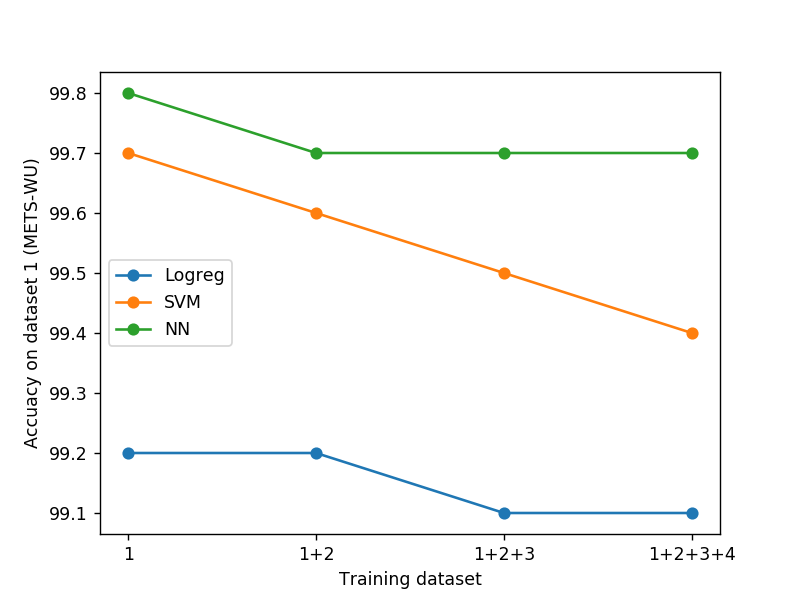

In [26]:
plot_one_dataset_all_classifiers(Td,0)

<IPython.core.display.Javascript object>


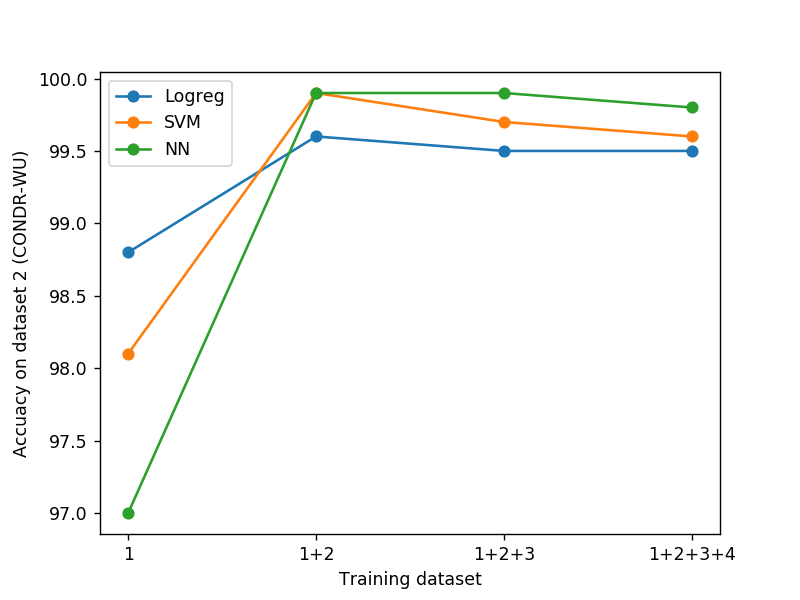

In [27]:
plot_one_dataset_all_classifiers(Td,1)

<IPython.core.display.Javascript object>


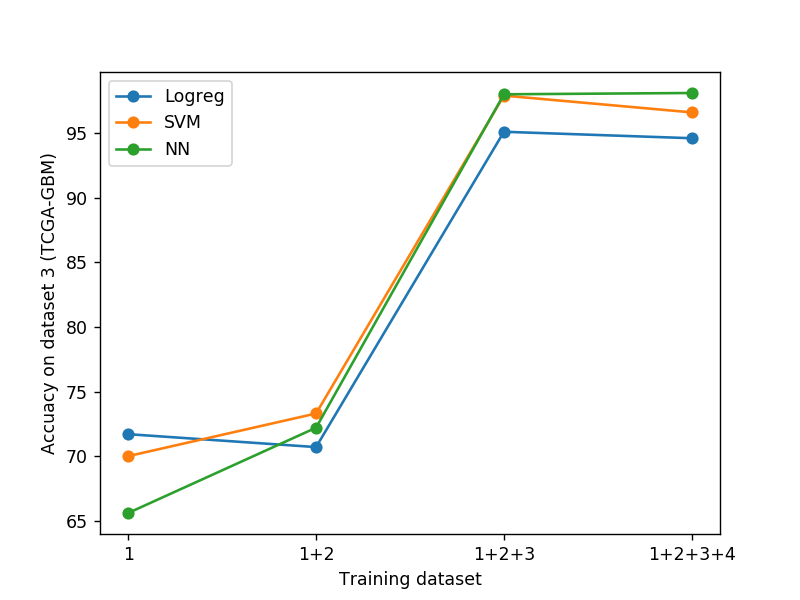

In [28]:
plot_one_dataset_all_classifiers(Td,2)

<IPython.core.display.Javascript object>


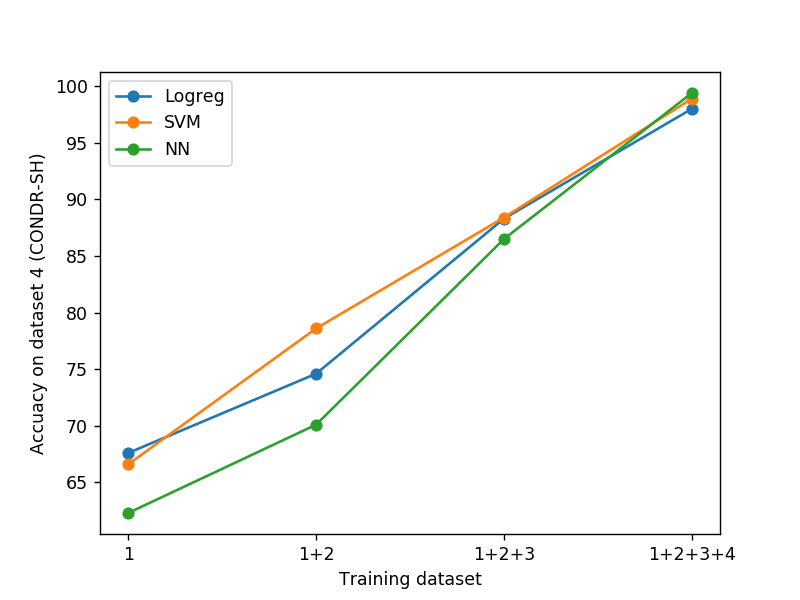

In [29]:
plot_one_dataset_all_classifiers(Td,3)

In [20]:
plot_all_datasets_one_classifier(T,'Testing accuracy')


NameError: name 'T' is not defined

In [30]:
xreg=[99.2, 99.3, 99, 99.5,99.1,99.0,99,99,99.2,98.9 ]
xsvc=[99.7,99.7,99.4,99.6,99.5,99.6,99.4,99.4,99.7,99.3 ]
xnn= [99.7,99.8,99.6,99.7,99.6,99.7,99.6,99.5,99.9,99.5  ]


In [31]:
#multinomial regression performance.
reg_acc=[[99.2, 99.2, 99.1, 99.1],[98.8,99.6,99.5,99.5],[71.7,70.7,95.1,94.6],[67.6,74.6,88.3,98]];
#svc performance
svc_acc=[[99.7,99.6,99.5,99.4],[98.1,99.9,99.7,99.6],[70.0,73.3,97.9,96.6],[66.6,78.6,88.4,98.9]];
#neural net performance
nn_acc= [[99.8,99.7,99.7,99.7],[97.0,99.9,99.9,99.8],[65.6,72.2,98.0,98.1],[62.3,70.1,86.5,99.4]];
voc=[258, 634, 1077, 1162]

<IPython.core.display.Javascript object>


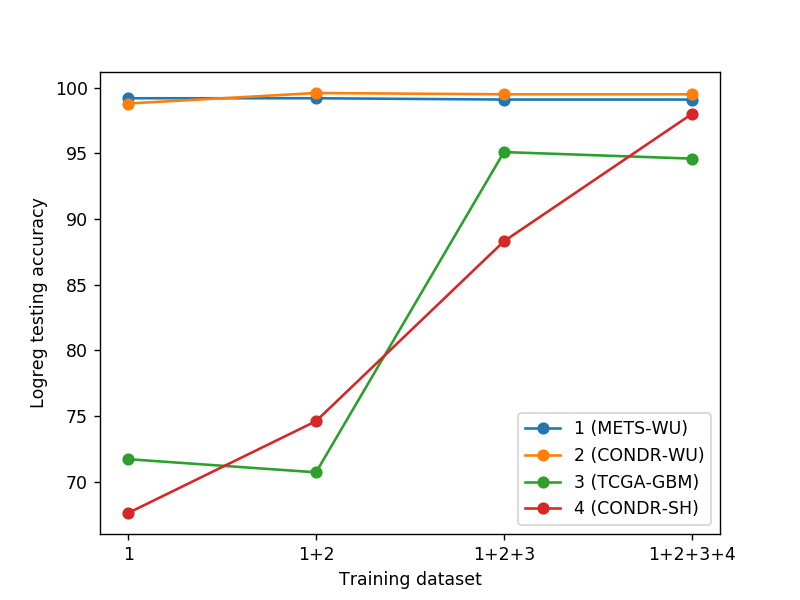

In [32]:
plot_all_datasets_one_classifier(reg_acc,'Logreg testing accuracy')


<IPython.core.display.Javascript object>


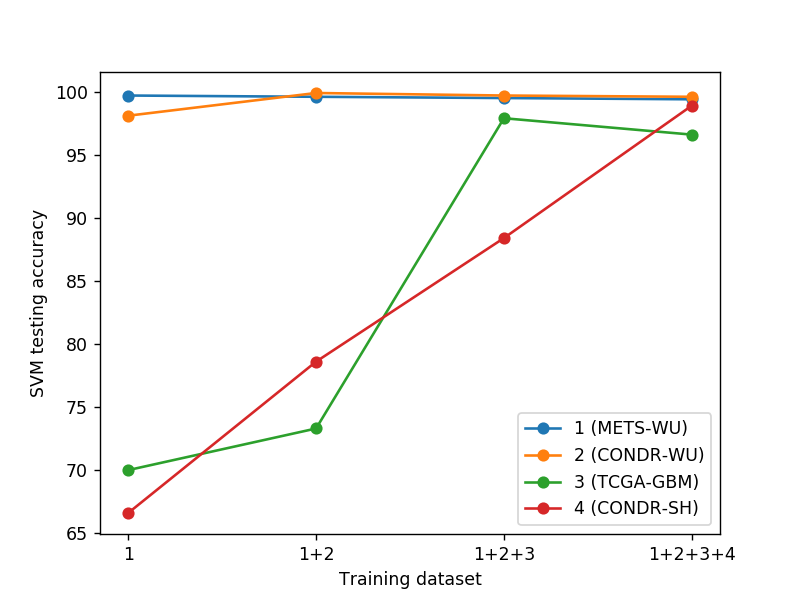

In [33]:
plot_all_datasets_one_classifier(svc_acc,'SVM testing accuracy')

<IPython.core.display.Javascript object>


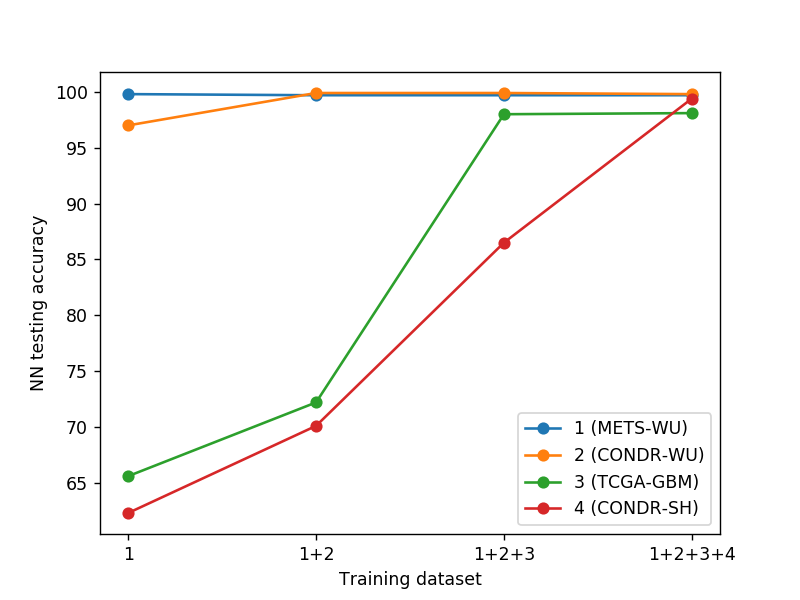

In [34]:
plot_all_datasets_one_classifier(nn_acc,'NN testing accuracy')

<IPython.core.display.Javascript object>


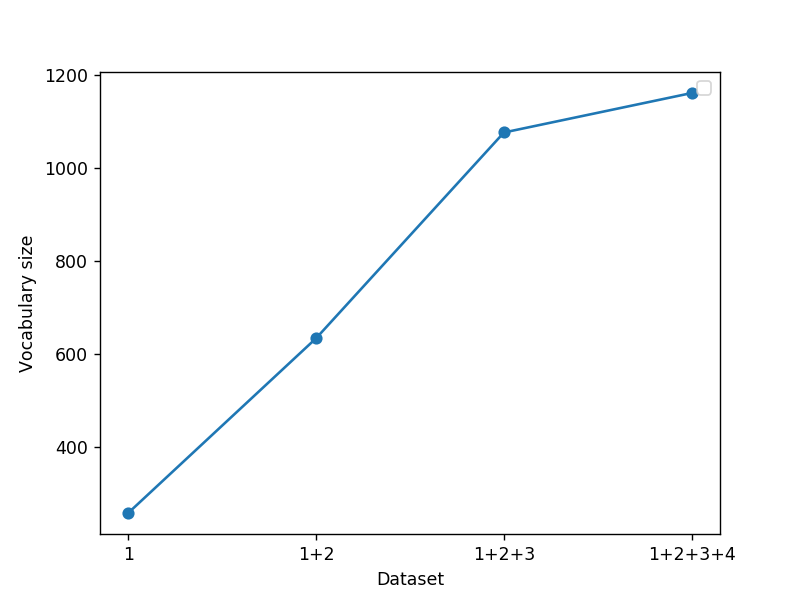

No handles with labels found to put in legend.


In [40]:
T=voc
x=[1,2,3,4]
plot(x,T,'-o');
legend(); xlabel('Dataset'); ylabel('Vocabulary size'); xticks([1,2,3,4],["1","1+2","1+2+3","1+2+3+4"]);

In [16]:
?ax
